In [1]:
import numpy as np
import math
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import sys
import os
import pandas as pd
import matplotlib.patches as mpatches
%matplotlib inline

# Plot Parameters

In [2]:
#parameters
plotdir = "./plots"
font = { 'size'   : 15}
plt.rc('font', **font)
markersize = 10 #12

#markers
colors = ['b','r','y','g','m','gray','gold','limegreen','c']
styles = ['o','s','v','^','D',">","<","*","h","H","+","1","2","3","4","8","p","d","|","_",".",","]

#styledict
styledict = {"thorsten": {"fontsize_annotation": 10, "roof_color": 'gray', "legend_points_ncol": 2, "frameon": False}, 
             "charlene": {"fontsize_annotation": 15, "roof_color": 'k', "legend_points_ncol": 1, "frameon": True}}

# Plot Code

In [3]:
#data dependent stuff
def plot_data(file_prefix, plot_label, marker_tag, marker_label, df):

    def byte2time(x):
        return x / byteroofs[0]


    def flop2time(y):
        return y / floproofs[-1]

    #pick style:
    style = styledict["thorsten"]
    fontsize_annotation = style["fontsize_annotation"]

    #print(df)

    df[['FLOPs Avg', 'L1 Bytes Avg', 'L2 Bytes Avg', 'DRAM Bytes Avg']] /= 1e9
    
    #fp16 data
    df_fp16         = df[df["Precision"] == "FP16"]
    BYTES_L1_fp16   = list(df_fp16["L1 Bytes Avg"])
    BYTES_L2_fp16   = list(df_fp16["L2 Bytes Avg"])
    BYTES_DRAM_fp16 = list(df_fp16["DRAM Bytes Avg"])
    FLOPS_fp16      = list(df_fp16["FLOPs Avg"])
    TIME_CUDA_fp16  = list(df_fp16["CUDA Time Avg"])
    labels_fp16     = ['FP16 ' +marker_label+" "+str(x) for x in list(df_fp16[marker_tag])]
    datasize_fp16   = len(FLOPS_fp16)
    
    #fp32 data
    df_fp32         = df[df["Precision"] == "FP32"]
    BYTES_L1_fp32   = list(df_fp32["L1 Bytes Avg"])
    BYTES_L2_fp32   = list(df_fp32["L2 Bytes Avg"])
    BYTES_DRAM_fp32 = list(df_fp32["DRAM Bytes Avg"])
    FLOPS_fp32      = list(df_fp32["FLOPs Avg"])
    TIME_CUDA_fp32  = list(df_fp32["CUDA Time Avg"])
    labels_fp32     = ['FP32 ' +marker_label+" "+str(x) for x in list(df_fp32[marker_tag])]
    datasize_fp32   = len(FLOPS_fp32)
    
    #print("{} {}".format(len(labels_fp16), len(labels_fp32)))
    
    #figure stuff
    fig = plt.figure(1, figsize=(10, 10))
    plt.clf()
    ax = fig.gca()
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('GBytes')
    ax.set_ylabel('GFLOPs')

    #ax.grid(True, which="major", ls="--", lw=1)
    #ax.grid(True, which="minor", ls="--", lw=0.5)

    bmin = min(min(BYTES_L1_fp16), min(BYTES_L2_fp16), min(BYTES_DRAM_fp16), min(BYTES_L1_fp32), min(BYTES_L2_fp32), min(BYTES_DRAM_fp32))
    bmax = max(max(BYTES_L1_fp16), max(BYTES_L2_fp16), max(BYTES_DRAM_fp16), max(BYTES_L1_fp32), max(BYTES_L2_fp32), max(BYTES_DRAM_fp32))
    fmin = min(FLOPS_fp16, FLOPS_fp32)
    fmax = max(FLOPS_fp16, FLOPS_fp32)
    tmin = min(TIME_CUDA_fp16, TIME_CUDA_fp32)
    tmax = max(max(TIME_CUDA_fp16), max(TIME_CUDA_fp32))
    tmax = math.ceil(tmax)

    # kernel launch overhead is ~ 4.2 us
    overhead = 4.2e-6
    
    
    #mem
    byteroofs = [828.8, 2996.7, 14*1024]
    byteroofnames = ['HBM', 'L2', 'L1']

    #flops
    floproofs = [7669.1, 15158.2, 29181.6, 125000.0]
    floproofnames = ['FP64', 'FP32', 'FP16', 'TC']
    
    # overhead ceilings
    oh_byteroof = byteroofs[0] * overhead
    oh_floproof = floproofs[-1] * overhead

    # max time ceilings
    mt_byteroof = byteroofs[0] * tmax
    mt_floproof = floproofs[-1] * tmax
    
    balance = floproofs[-1] / byteroofs[0]

    # plot memory ceilings
    #ax.plot([oh_byteroof, oh_byteroof], [0, oh_floproof], c=colors[-1])
    # plot flop ceilings
    #ax.plot([0, oh_byteroof], [oh_floproof, oh_floproof], c=colors[-1])

    #ax.annotate("Overhead-bound", xy=(bmin, fmin), xytext=(5,10), textcoords="offset points",
    #        color=colors[-1], horizontalalignment='left', fontsize=fontsize_annotation,
    #        verticalalignment='bottom')

    #some handles
    marker_handles = []
        
    max_flop_ceiling, max_byte_ceiling = 0.0, 0.0
    min_flop_ceiling, min_byte_ceiling = float("inf"), float("inf")
    
    # FP16
    for i in range(datasize_fp16):
        ax.plot(float(BYTES_DRAM_fp16[i]),float(FLOPS_fp16[i]), c=colors[i], marker=styles[0], linestyle='None', ms=markersize)
        
        local_balance = float(FLOPS_fp16[i]) / float(BYTES_DRAM_fp16[i])

        flop_ceilings, byte_ceilings = [], []
        for flop in floproofs:
            flop_ceilings.append(TIME_CUDA_fp16[i] * flop)
            byte_ceilings.append(TIME_CUDA_fp16[i] * flop / local_balance)
            
        if local_balance > balance:
            flop_vertex = TIME_CUDA_fp16[i] * floproofs[-1]
            byte_vertex = flop_vertex / local_balance
            
            label = floproofnames[-1]
            ax.annotate(label, xy=(byte_vertex, flop_vertex), xytext=(5,0), textcoords="offset points",
                        color=colors[i], horizontalalignment='left', fontsize=fontsize_annotation)
        else:
            byte_vertex = TIME_CUDA_fp16[i] * byteroofs[0]
            flop_vertex = byte_vertex * local_balance
            
        ax.plot(byte_vertex,flop_vertex, c=colors[i], marker=styles[0], mfc='none', linestyle='None', ms=markersize)
        ax.plot([BYTES_DRAM_fp16[i], byte_vertex], [FLOPS_fp16[i], flop_vertex], c=colors[i])
        #label = floproofnames[-1]
        
        min_flop_ceiling, min_byte_ceiling = min(min_flop_ceiling, FLOPS_fp16[i]), min(min_byte_ceiling, BYTES_DRAM_fp16[i])
        max_flop_ceiling, max_byte_ceiling = max(max_flop_ceiling, flop_vertex), max(max_byte_ceiling, byte_vertex)

        for j in range(len(flop_ceilings)):
            if (FLOPS_fp16[i] <= flop_ceilings[j] < flop_vertex) and (BYTES_DRAM_fp16[i] <= byte_ceilings[j] < byte_vertex):
                ax.plot(byte_ceilings[j],flop_ceilings[j], c=colors[i], marker=styles[0], linestyle='None', ms=5)
                label = floproofnames[j] #+ ' {0:.1f}'.format(float(flop_ceiling))
                ax.annotate(label, xy=(byte_ceilings[j], flop_ceilings[j]), xytext=(5,-10), textcoords="offset points",
                            color=colors[i], horizontalalignment='left', fontsize=fontsize_annotation)

    # FP32
    for i in range(datasize_fp32):
        ax.plot(float(BYTES_DRAM_fp32[i]),float(FLOPS_fp32[i]), c=colors[datasize_fp16 + i], marker=styles[0], linestyle='None', ms=markersize)
        
        local_balance = float(FLOPS_fp32[i]) / float(BYTES_DRAM_fp32[i])
        
        flop_ceilings, byte_ceilings = [], []
        for flop in floproofs:
            flop_ceilings.append(TIME_CUDA_fp32[i] * flop)
            byte_ceilings.append(TIME_CUDA_fp32[i] * flop / local_balance)
            
        if local_balance > balance:
            flop_vertex = TIME_CUDA_fp32[i] * floproofs[-1]
            byte_vertex = flop_vertex / local_balance
        else:
            byte_vertex = TIME_CUDA_fp32[i] * byteroofs[0]
            flop_vertex = byte_vertex * local_balance
            
        ax.plot(byte_vertex,flop_vertex, c=colors[datasize_fp16 + i], marker=styles[0], mfc='none', linestyle='None', ms=markersize)
        ax.plot([BYTES_DRAM_fp32[i], byte_vertex], [FLOPS_fp32[i], flop_vertex], c=colors[datasize_fp16 + i])
        #label = floproofnames[-1]
        #ax.annotate(label, xy=(byte_vertex, flop_vertex), xytext=(5,0), textcoords="offset points",
        #                    color=colors[datasize_fp16 + i], horizontalalignment='left', fontsize=fontsize_annotation)
        
        min_flop_ceiling, min_byte_ceiling = min(min_flop_ceiling, FLOPS_fp32[i]), min(min_byte_ceiling, BYTES_DRAM_fp32[i])
        max_flop_ceiling, max_byte_ceiling = max(max_flop_ceiling, flop_vertex), max(max_byte_ceiling, byte_vertex)

        for j in range(len(flop_ceilings)):
            if (FLOPS_fp32[i] <= flop_ceilings[j] < flop_vertex) and (BYTES_DRAM_fp32[i] <= byte_ceilings[j] < byte_vertex):
                ax.plot(byte_ceilings[j],flop_ceilings[j], c=colors[datasize_fp16 + i], marker=styles[0], linestyle='None', ms=5)
                label = floproofnames[j] #+ ' {0:.1f}'.format(float(flop_ceiling))
                ax.annotate(label, xy=(byte_ceilings[j], flop_ceilings[j]), xytext=(5,-10), textcoords="offset points",
                            color=colors[datasize_fp16 + i], horizontalalignment='left', fontsize=fontsize_annotation)
                
    bmin = pow(10, math.log(min_byte_ceiling)//math.log(10))
    fmin = pow(10, math.log(min_flop_ceiling)//math.log(10)) 
    bmax = pow(10, math.log(max_byte_ceiling)//math.log(10) + 1)
    fmax = pow(10, math.log(max_flop_ceiling)//math.log(10) + 1)

    ax.plot([oh_byteroof, mt_byteroof], [oh_floproof, mt_floproof], c='k')

    bsecax = ax.secondary_xaxis('top', functions=(byte2time, flop2time))
    bsecax.set_xlabel('Byte time')
    
    fsecax = ax.secondary_yaxis('right', functions=(flop2time, byte2time))
    fsecax.set_ylabel('FLOP time')

    ax.set_xlim(bmin, bmax)
    ax.set_ylim(fmin, fmax)
    
    #legend 2:
    patch_handles = []
    for i in range(len(labels_fp16)):
        patch_handles.append(mpatches.Patch(color=colors[i],label = labels_fp16[i]))
    for i in range(len(labels_fp32)):
        patch_handles.append(mpatches.Patch(color=colors[datasize_fp16 + i],label = labels_fp32[i]))
    leg1 = ax.legend(handles = patch_handles,loc='upper left', scatterpoints = 1,
            frameon=style["frameon"], fontsize = 12)

    #title
    #if plot_label:
    #    ax.text(ax.get_xlim()[0]*1.1, ax.get_ylim()[1]*1.5, plot_label, horizontalalignment='left', verticalalignment='top')
   
    #plt.show()

    #save figure
    plt.tight_layout()
    plt.savefig(file_prefix+'.png')
    plt.savefig(file_prefix+'.eps')

# Load Data

In [4]:
datadir = "../results/tf2_nsight/results_NHWC"
combineddf = pd.read_csv(os.path.join(datadir,"combined_profile.csv"))

/usr/common/software/python/3.7-anaconda-2019.10/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


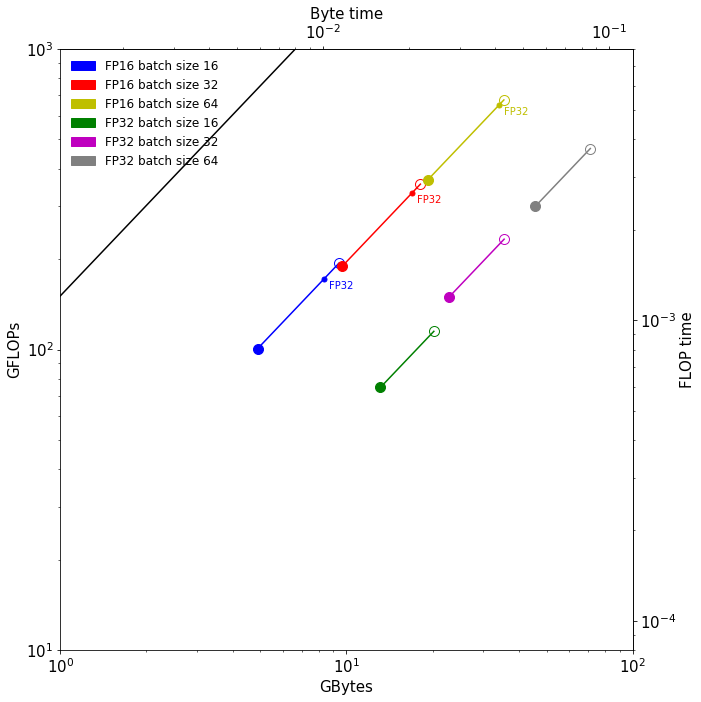

In [5]:
#plot vs batchsize
directory="plots/batch_size"
try:
    os.stat(directory)
except:
    os.mkdir(directory)
    
features = list(combineddf[["Network Name", "Input Shape", "Kernel Shape", "Stride Size", "Pass"]].apply(lambda x: (x["Network Name"], \
                                                                                          x["Input Shape"], \
                                                                                          x["Kernel Shape"], \
                                                                                          x["Stride Size"], \
                                                                                          x["Pass"]), axis=1).unique())

for idx,feature in enumerate(features):
    
    #project the data
    selectdf = combineddf[ (combineddf[ "Network Name" ] == feature[0]) & \
                           (combineddf[ "Input Shape" ] == feature[1]) & \
                           (combineddf[ "Kernel Shape" ] == feature[2]) & \
                           (combineddf[ "Stride Size" ] == feature[3]) & \
                           (combineddf[ "Pass" ] == feature[4]) ]
    
    if len(selectdf["Batch Size"].unique()) == 1:
        continue
    
    #label
    plot_label = 'V100, tf.nn.conv2d, '+feature[0].split("-")[0]+', '+feature[1]+', '+feature[2]+', '+str(feature[3])+', '+feature[4]
    plot_file = os.path.join(directory, plot_label.replace(", ","_"))
    plot_label = None
    plot_data(plot_file, plot_label, "Batch Size", "batch size", selectdf)

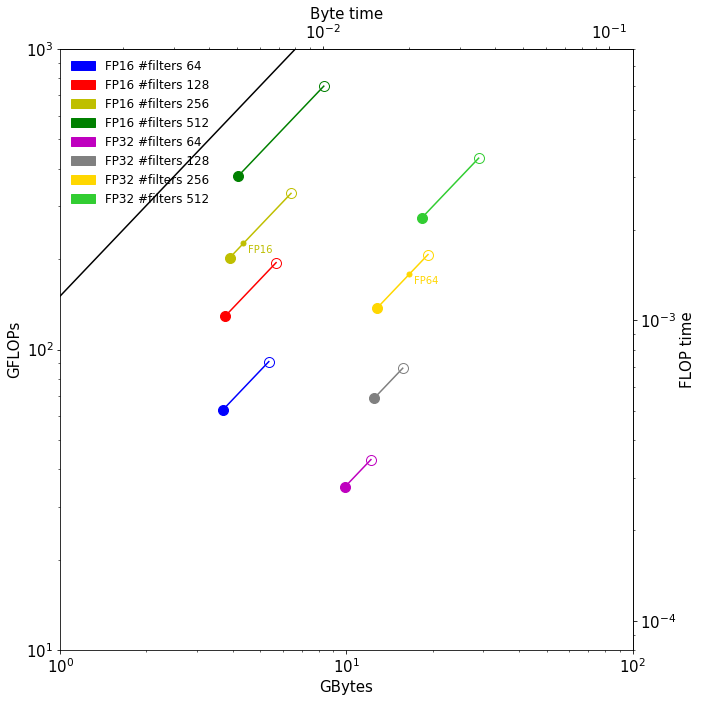

In [6]:
#plot vs num filters
directory="plots/num_filters"
try:
    os.stat(directory)
except:
    os.mkdir(directory)

features = list(combineddf[["Network Name", "Input Shape", "Batch Size", "Stride Size", "Pass", "Kernel Shape"]].apply(lambda x: (x["Network Name"], \
                                                                                          x["Input Shape"], \
                                                                                          x["Batch Size"], \
                                                                                          x["Stride Size"], \
                                                                                          x["Pass"], \
                                                                                          x["Kernel Shape"].split("x")[-1], \
                                                                                          "x".join(x["Kernel Shape"].split("x")[:-1])), axis=1).unique())

#do the plotting
for idx,feature in enumerate(features):
    
    #project the data
    selectdf = combineddf[ (combineddf[ "Network Name" ] == feature[0]) & \
                           (combineddf[ "Input Shape" ] == feature[1]) & \
                           (combineddf[ "Batch Size" ] == feature[2]) & \
                           (combineddf[ "Stride Size" ] == feature[3]) & \
                           (combineddf[ "Pass" ] == feature[4]) & \
                           (combineddf[ "Kernel Shape" ].str.startswith(feature[6]))].copy()
    selectdf[ "Num Filters" ] = selectdf["Kernel Shape"].str.split("x").apply(lambda x: int(x[-1]))
    
    #sort data
    selectdf.sort_values("Num Filters", ascending=True, inplace=True)
    
    if len(selectdf["Kernel Shape"].unique()) == 1:
        continue
    
    #label
    plot_label = 'V100, tf.nn.conv2d, '+feature[0].split("-")[0]+', '+feature[1]+', '+feature[6]+', '+str(feature[2])+', '+str(feature[3])+', '+feature[4]
    plot_file = os.path.join(directory, plot_label.replace(", ","_"))
    plot_label = None
    plot_data(plot_file, plot_label, "Num Filters", "#filters", selectdf)

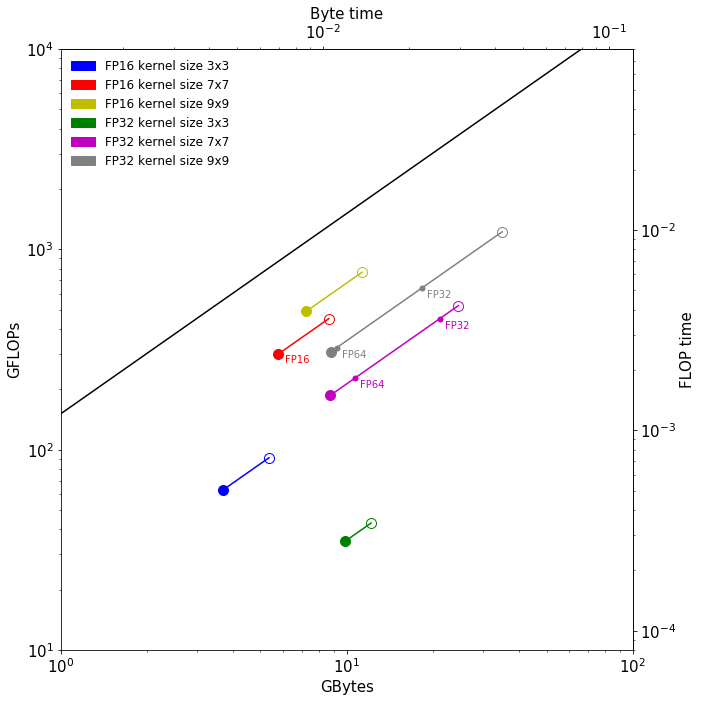

In [7]:
#plot vs kernel size
directory="plots/kernel_size"
try:
    os.stat(directory)
except:
    os.mkdir(directory)

features = list(combineddf[["Network Name", "Input Shape", "Batch Size", "Stride Size", "Pass", "Kernel Shape"]].apply(lambda x: (x["Network Name"], \
                                                                                          x["Input Shape"], \
                                                                                          x["Batch Size"], \
                                                                                          x["Stride Size"], \
                                                                                          x["Pass"], \
                                                                                          x["Kernel Shape"].split("x")[-1], \
                                                                                          "x".join(x["Kernel Shape"].split("x")[:-1])), axis=1).unique())

#do the plotting
for idx,feature in enumerate(features):
    
    #project the data
    selectdf = combineddf[ (combineddf[ "Network Name" ] == feature[0]) & \
                           (combineddf[ "Input Shape" ] == feature[1]) & \
                           (combineddf[ "Batch Size" ] == feature[2]) & \
                           (combineddf[ "Stride Size" ] == feature[3]) & \
                           (combineddf[ "Pass" ] == feature[4])].copy()
    selectdf[ "Num Filters" ] = selectdf["Kernel Shape"].str.split("x").apply(lambda x: int(x[-1]))
    selectdf[ "Kernel Size" ] = selectdf["Kernel Shape"].str.split("x").apply(lambda x: "x".join(x[:-2]))
    selectdf = selectdf[ selectdf["Num Filters"] == int(feature[5]) ]
    
    #sort data
    selectdf.sort_values("Kernel Size", ascending=True, inplace=True)
    
    if len(selectdf["Kernel Shape"].unique()) == 1:
        continue
    
    #label
    plot_label = 'V100, tf.nn.conv2d, '+feature[0].split("-")[0]+', '+feature[1]+', '+feature[5]+', '+str(feature[2])+', '+str(feature[3])+', '+feature[4]
    plot_file = os.path.join(directory, plot_label.replace(", ","_"))
    plot_label = None
    plot_data(plot_file, plot_label, "Kernel Size", "kernel size", selectdf)

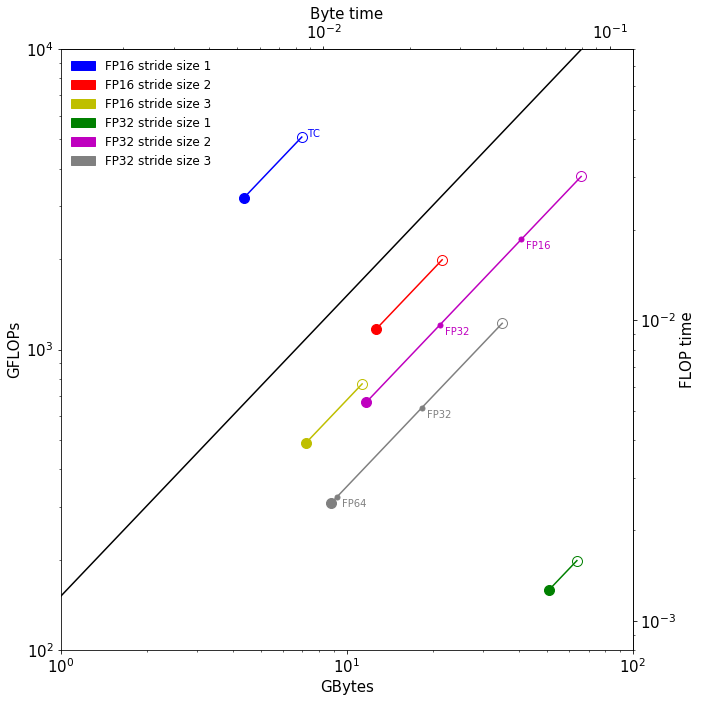

In [8]:
#plot vs stride size
directory="plots/stride_size"
try:
    os.stat(directory)
except:
    os.mkdir(directory)

features = list(combineddf[["Network Name", "Input Shape", "Batch Size", "Kernel Shape", "Pass"]].apply(lambda x: (x["Network Name"], \
                                                                                          x["Input Shape"], \
                                                                                          x["Batch Size"], \
                                                                                          x["Kernel Shape"], \
                                                                                          x["Pass"]), axis=1).unique())

#do the plotting
for idx,feature in enumerate(features):
    
    #project the data
    selectdf = combineddf[ (combineddf[ "Network Name" ] == feature[0]) & \
                           (combineddf[ "Input Shape" ] == feature[1]) & \
                           (combineddf[ "Batch Size" ] == feature[2]) & \
                           (combineddf[ "Kernel Shape" ] == feature[3]) & \
                           (combineddf[ "Pass" ] == feature[4])].copy()
    
    #sort data
    selectdf.sort_values("Stride Size", ascending=True, inplace=True)
    
    if len(selectdf["Stride Size"].unique()) == 1:
        continue
    
    #label
    plot_label = 'V100, tf.nn.conv2d, '+feature[0].split("-")[0]+', '+feature[1]+', '+feature[3]+', '+str(feature[2])+', '+feature[4]
    plot_file = os.path.join(directory, plot_label.replace(", ","_"))
    plot_label = None
    plot_data(plot_file, plot_label, "Stride Size", "stride size", selectdf)

In [9]:
combineddf.loc[ (combineddf["Network Name"] == "ResNet50-2") &\
            (combineddf["Input Shape"] == "112x112x64") &\
            (combineddf["Kernel Shape"] == "9x9x64x64") & \
            (combineddf["Precision"] == "FP16") & \
            (combineddf["Pass"] == "backward"), ["FP32 Performance GFlop/s", "FP16 Performance GFlop/s"]]

,FP32 Performance GFlop/s,FP16 Performance GFlop/s
36,7042.138928,106.392570
38,5525.154526,89.318675
40,5270.266023,88.465379


In [10]:
#select good plots
#bs
!mkdir -p plots/box
!cp plots/batch_size/V100_tf.nn.conv2d_ResNet50_112x112x64_3x3x64x64_2_forward.png plots/box/plot_tf_bs_fw.png
!cp plots/batch_size/V100_tf.nn.conv2d_ResNet50_112x112x64_3x3x64x64_2_backward.png plots/box/plot_tf_bs_bw.png
!cp plots/batch_size/V100_tf.nn.conv2d_ResNet50_112x112x64_3x3x64x64_2_forward.eps plots/box/plot_tf_bs_fw.eps
!cp plots/batch_size/V100_tf.nn.conv2d_ResNet50_112x112x64_3x3x64x64_2_backward.eps plots/box/plot_tf_bs_bw.eps
#nf
!cp plots/num_filters/V100_tf.nn.conv2d_ResNet50_112x112x64_3x3x64_16_2_forward.png plots/box/plot_tf_nf_fw.png
!cp plots/num_filters/V100_tf.nn.conv2d_ResNet50_112x112x64_3x3x64_16_2_backward.png plots/box/plot_tf_nf_bw.png
!cp plots/num_filters/V100_tf.nn.conv2d_ResNet50_112x112x64_3x3x64_16_2_forward.eps plots/box/plot_tf_nf_fw.eps
!cp plots/num_filters/V100_tf.nn.conv2d_ResNet50_112x112x64_3x3x64_16_2_backward.eps plots/box/plot_tf_nf_bw.eps
#ks
!cp plots/kernel_size/V100_tf.nn.conv2d_ResNet50_112x112x64_64_16_2_forward.png plots/box/plot_tf_ks_fw.png
!cp plots/kernel_size/V100_tf.nn.conv2d_ResNet50_112x112x64_64_16_2_backward.png plots/box/plot_tf_ks_bw.png
!cp plots/kernel_size/V100_tf.nn.conv2d_ResNet50_112x112x64_64_16_2_forward.eps plots/box/plot_tf_ks_fw.eps
!cp plots/kernel_size/V100_tf.nn.conv2d_ResNet50_112x112x64_64_16_2_backward.eps plots/box/plot_tf_ks_bw.eps
#ss
!cp plots/stride_size/V100_tf.nn.conv2d_ResNet50_112x112x64_3x3x64x64_16_forward.png plots/box/plot_tf_ss_fw.png
!cp plots/stride_size/V100_tf.nn.conv2d_ResNet50_112x112x64_3x3x64x64_16_backward.png plots/box/plot_tf_ss_bw.png
!cp plots/stride_size/V100_tf.nn.conv2d_ResNet50_112x112x64_3x3x64x64_16_forward.eps plots/box/plot_tf_ss_fw.eps
!cp plots/stride_size/V100_tf.nn.conv2d_ResNet50_112x112x64_3x3x64x64_16_backward.eps plots/box/plot_tf_ss_bw.eps